# New Data Analysis

## Import Lib

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get All Data

In [2]:
def get_all_data(files_path):
    df = pd.read_csv(files_path, index_col=[0])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.reset_index(drop=True, inplace=True)
    return df[['timestamp', 'SOH', 'System voltage', 'System Current', 'SOC']]

### All data

In [3]:
files_name = '../data/main_all_dataset.csv'
all_data = get_all_data(files_name)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33239030 entries, 0 to 33239029
Data columns (total 5 columns):
 #   Column          Dtype              
---  ------          -----              
 0   timestamp       datetime64[ns, UTC]
 1   SOH             int64              
 2   System voltage  int64              
 3   System Current  int64              
 4   SOC             int64              
dtypes: datetime64[ns, UTC](1), int64(4)
memory usage: 1.2 GB


### temp4 data

In [8]:
files_name = '../data/temp4_datas.csv'
temp4 = pd.read_csv(files_name)
temp4['timestamp'] = pd.to_datetime(temp4['timestamp'])
temp4 = temp4[['timestamp', 'c0', 'ah']]

In [9]:
temp4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44235 entries, 0 to 44234
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  44235 non-null  datetime64[ns, UTC]
 1   c0         44235 non-null  float64            
 2   ah         44235 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 1.0 MB


## Data Preprocessing

In [5]:
def calculate_sum_to_hourly(data, column):
    return data[column].resample('60min').apply(lambda x: x.sum() * (1/3600))


def resample_with_change_rate(df):
    df = df[df['System voltage'] != 0]

    df['Power'] = df['System voltage'] * df['System Current'] 

    '''
    df['Voltage_change'] = df['System voltage'].diff()
    df['Current_change'] = df['System Current'].diff()
    df['Power_change'] = df['Power'].diff()
    df['SOC_change'] = df['SOC'].diff() 
    '''
    
    df.set_index('timestamp', inplace=True)
    df_resampled = df.resample('60min').mean()
    '''
    df_resampled['Coulomb_Counting'] = calculate_sum_to_hourly(df, 'System Current')
    df_resampled['Energy'] = calculate_sum_to_hourly(df, 'Power')
    '''
    df_resampled['SOC'] = df['SOC'].resample('60min').first()
    df_resampled['SOH'] = df['SOH'].resample('60min').last()
    # df_resampled = df_resampled.fillna(0)
    df_resampled.reset_index(inplace=True)
    
    return df_resampled[df_resampled['SOH'] > 0]


def resample_data(df):
    df.set_index('timestamp', inplace=True)
    resampled_df = df.resample('60min').first()
    resampled_df.reset_index(inplace=True)
    return resampled_df


In [10]:
temp_resample = resample_data(temp4)
temp_resample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  7430 non-null   datetime64[ns, UTC]
 1   c0         7386 non-null   float64            
 2   ah         7386 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 174.3 KB


In [6]:
df = resample_with_change_rate(all_data)

/tmp/ipykernel_2561699/2509407347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Power'] = df['System voltage'] * df['System Current']


In [7]:
df = df.dropna()

In [11]:
df.set_index('timestamp', inplace=True)
temp_resample.set_index('timestamp', inplace=True)

merged_df = pd.merge_asof(df, temp_resample, left_index=True, right_index=True, direction='nearest')
merged_df

,SOH,System voltage,System Current,SOC,Power,c0,ah
timestamp,,,,,,,
2023-06-09 16:00:00+00:00,983.0,13642.029444,13.787778,617.0,175689.798611,11594.76667,184549.1503
2023-06-09 17:00:00+00:00,983.0,13638.848889,9.123333,607.0,111300.628333,11594.76667,184549.1503
2023-06-09 18:00:00+00:00,983.0,13679.401944,-6.474444,599.0,-105628.650000,11594.76667,184549.1503
2023-06-09 19:00:00+00:00,983.0,13673.374722,1.213889,603.0,260.985833,11594.76667,184549.1503
2023-06-09 20:00:00+00:00,983.0,13656.246944,2.374722,602.0,20401.235556,11594.76667,184549.1503
...,...,...,...,...,...,...,...
2024-06-30 11:00:00+00:00,960.0,13597.109167,12.568056,533.0,170496.891944,19610.08333,401389.8661
2024-06-30 12:00:00+00:00,960.0,13548.466111,21.914167,523.0,295735.696944,19610.08333,401389.8661
2024-06-30 13:00:00+00:00,960.0,13499.209167,28.736667,505.0,385735.834167,19610.08333,401389.8661


In [12]:
merged_df.reset_index(inplace=True)

### Smoothing SOH

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.54838e-43): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


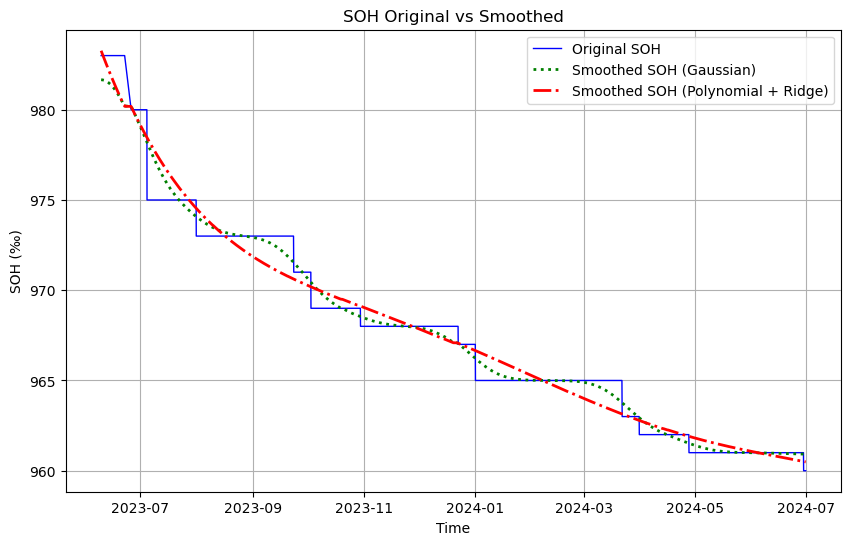

In [30]:
df_soh_smooth = merged_df.copy()

# 準備數據
df_soh_smooth['timestamp'] = pd.to_datetime(df_soh_smooth['timestamp'])  # 假設 timestamp 是時間戳
df_soh_smooth['time_index'] = np.arange(len(df_soh_smooth))  # 將時間轉換為數字索引

# 1. 移動平均平滑
df_soh_smooth['SOH_smooth_ma'] = df_soh_smooth['SOH'].rolling(window=400).mean()  # 10步長的移動平均

# 2. 高斯平滑
df_soh_smooth['SOH_smooth_gauss'] = gaussian_filter1d(df_soh_smooth['SOH'], sigma=300)  # sigma越大，平滑程度越高

# 3. PolynomialFeatures + Ridge 平滑
degree = 5 # 可以調整多項式的次數
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(df_soh_smooth[['time_index']], df_soh_smooth['SOH'])
df_soh_smooth['SOH_smooth_poly'] = model.predict(df_soh_smooth[['time_index']])

# 繪製原始SOH和三種平滑方法的結果
plt.figure(figsize=(10, 6))

# 原始SOH
plt.plot(merged_df['timestamp'], merged_df['SOH'], label='Original SOH', color='blue', linewidth=1)

# 移動平均平滑
#plt.plot(df_soh_smooth['timestamp'], df_soh_smooth['SOH_smooth_ma'], label='Smoothed SOH (Moving Average)', color='orange', linestyle='--', linewidth=2)

# 高斯平滑
plt.plot(df_soh_smooth['timestamp'], df_soh_smooth['SOH_smooth_gauss'], label='Smoothed SOH (Gaussian)', color='green', linestyle=':', linewidth=2)

# PolynomialFeatures + Ridge 平滑
plt.plot(df_soh_smooth['timestamp'], df_soh_smooth['SOH_smooth_poly'], label='Smoothed SOH (Polynomial + Ridge)', color='red', linestyle='-.', linewidth=2)

# 圖片設置
plt.title('SOH Original vs Smoothed')
plt.xlabel('Time')
plt.ylabel('SOH (‰)')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
merged_df['SOH'] = df_soh_smooth['SOH_smooth_poly']
merged_df

,timestamp,SOH,System voltage,System Current,SOC,Power,c0,ah
0,2023-06-09 16:00:00+00:00,983.269813,13642.029444,13.787778,617.0,175689.798611,11594.76667,184549.1503
1,2023-06-09 17:00:00+00:00,983.258649,13638.848889,9.123333,607.0,111300.628333,11594.76667,184549.1503
2,2023-06-09 18:00:00+00:00,983.247492,13679.401944,-6.474444,599.0,-105628.650000,11594.76667,184549.1503
3,2023-06-09 19:00:00+00:00,983.236342,13673.374722,1.213889,603.0,260.985833,11594.76667,184549.1503
4,2023-06-09 20:00:00+00:00,983.225201,13656.246944,2.374722,602.0,20401.235556,11594.76667,184549.1503
...,...,...,...,...,...,...,...,...
9081,2024-06-30 11:00:00+00:00,960.491822,13597.109167,12.568056,533.0,170496.891944,19610.08333,401389.8661
9082,2024-06-30 12:00:00+00:00,960.490980,13548.466111,21.914167,523.0,295735.696944,19610.08333,401389.8661
9083,2024-06-30 13:00:00+00:00,960.490138,13499.209167,28.736667,505.0,385735.834167,19610.08333,401389.8661
9084,2024-06-30 14:00:00+00:00,960.489296,13521.030000,-1.698611,482.0,-25629.740556,19610.08333,401389.8661


In [32]:
merged_df.to_csv("../merged_data.csv", index=False)

In [10]:
df = df.dropna()

In [15]:
df = merged_df[308:]

### Train-test split

In [16]:
train_size = int(len(df)* 0.75)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f'Training set size: {train.shape}, Test set size: {test.shape}')

Training set size: (6583, 8), Test set size: (2195, 8)


### Scaler

In [17]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train.set_index('timestamp', inplace=True)
train_scaled = scaler.fit_transform(train)

test.set_index('timestamp', inplace=True)
test_scaled = scaler.fit_transform(test)


In [18]:
print(f'test size:{test_scaled.shape}')
print(f'train size:{train_scaled.shape}')

test size:(2195, 7)
train size:(6583, 7)


### Create window

In [19]:
input_chunk_length = 168

In [20]:
import torch

def create_time_windows(data, input_length):
    X, y = [], []
    for i in range(len(data) - input_length):
        X.append(data[i:(i + input_length)])
        y.append(data[i + input_length])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [21]:
trainX, trainY = create_time_windows(train_scaled, input_chunk_length)
# valX, valY = create_dataset(val_scaled, 168)

print(trainX.shape)
print(trainY.shape)

torch.Size([6415, 168, 7])
torch.Size([6415, 7])


/tmp/ipykernel_1467960/162926623.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


## build Model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.linear(out[:, -1, :])
        return out

### hyperparameters

In [24]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# train
batch_size = 128
learning_rate = 0.0005
num_epochs = 500

# model
input_dim = 7
hidden_dim = 128
output_dim = 7
num_layer = 5
model = GRUModel(input_dim, hidden_dim, output_dim, num_layer).to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



### Training 

In [25]:
train_losses = []
# val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [10/200], Average Loss: 0.3573
Epoch [20/200], Average Loss: 0.3403
Epoch [30/200], Average Loss: 0.3280
Epoch [40/200], Average Loss: 0.3189
Epoch [50/200], Average Loss: 0.3087
Epoch [60/200], Average Loss: 0.2961
Epoch [70/200], Average Loss: 0.2807
Epoch [80/200], Average Loss: 0.2708
Epoch [90/200], Average Loss: 0.2433
Epoch [100/200], Average Loss: 0.2176
Epoch [110/200], Average Loss: 0.1962
Epoch [120/200], Average Loss: 0.1696
Epoch [130/200], Average Loss: 0.1494
Epoch [140/200], Average Loss: 0.1297
Epoch [150/200], Average Loss: 0.1135
Epoch [160/200], Average Loss: 0.1034
Epoch [170/200], Average Loss: 0.0936
Epoch [180/200], Average Loss: 0.0817
Epoch [190/200], Average Loss: 0.0762
Epoch [200/200], Average Loss: 0.0688


## Eval

In [26]:
testX, testY = create_time_windows(test_scaled, input_chunk_length)
test_dataset = TensorDataset(testX)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
model.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].to(device)
        output = model(batch)
        predictions.append(output.cpu().numpy())

predicted = np.concatenate(predictions)

In [28]:
predicted_original = scaler.inverse_transform(predicted.reshape(-1, predicted.shape[-1])).reshape(predicted.shape)
testY_original = scaler.inverse_transform(testY.reshape(-1, testY.shape[-1])).reshape(testY.shape)

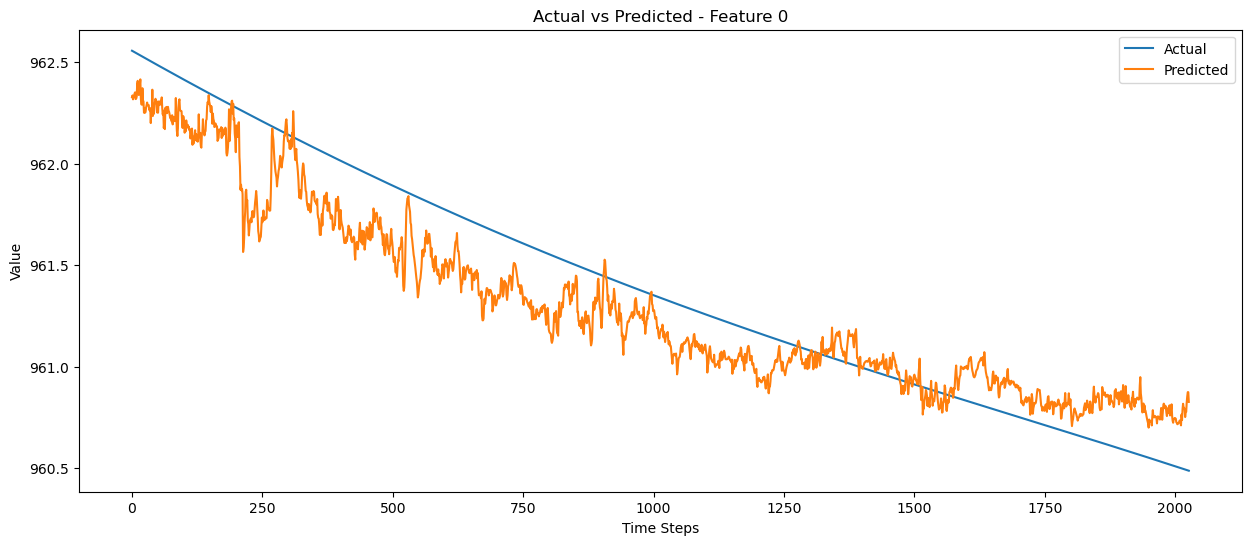

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(testY_original[:, 0], label='Actual')
plt.plot(predicted_original[:, 0], label='Predicted')
plt.title('Actual vs Predicted - Feature 0')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [30]:
mse = np.mean((testY_original[:, 0] - predicted_original[:, 0]) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(testY_original[:, 0] - predicted_original[:, 0]))

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 0.0487
RMSE: 0.2207
MAE: 0.1907


### Feature predictions

In [51]:

def predict_future(model, last_observed, steps=1000, scaler=None):
    model.eval()  # 設置模型為評估模式
    future_predictions = []
    current_input = last_observed.clone().to(device)

    with torch.no_grad():
        for _ in range(steps):
            prediction = model(current_input.unsqueeze(0))
            future_predictions.append(prediction.squeeze().cpu().numpy())
            
            # 更新輸入，移除最舊的時間步，添加新的預測
            current_input = torch.cat((current_input[1:], prediction), dim=0)

    future_predictions = np.array(future_predictions)
    
    # 如果使用了scaler，則反向轉換預測結果
    if scaler:
        future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions


initial_sequence = trainX[0] # 假設 testX 已經是正確的形狀 [batch, time_steps, features]

# 設定要預測的未來時間步數
num_future_steps = 4000 # 例如，預測未來 n 個時間步

# 進行遞迴預測
future_predictions = predict_future(model, initial_sequence, num_future_steps, scaler)



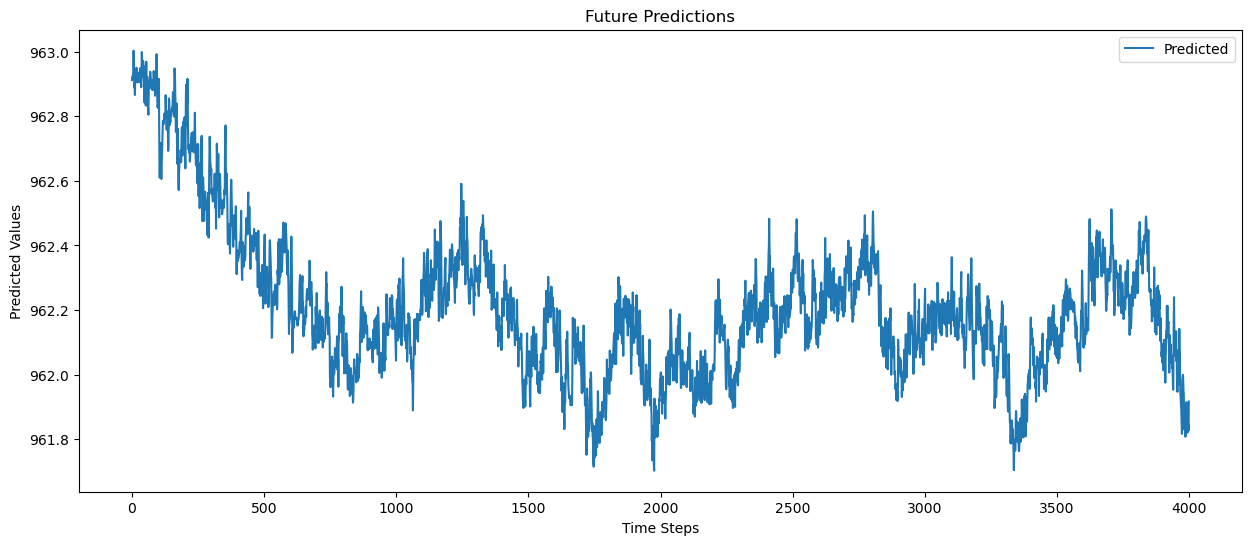

In [53]:
# 繪製預測結果
plt.figure(figsize=(15, 6))
plt.plot(future_predictions[:, 0], label='Predicted')
plt.title('Future Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

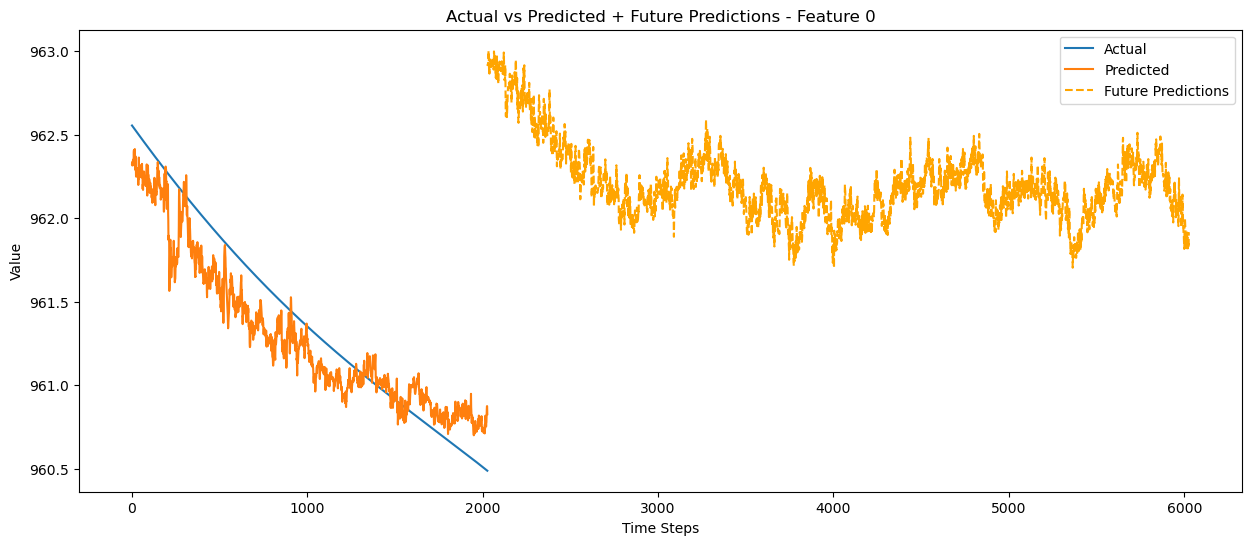

In [56]:
plt.figure(figsize=(15, 6))

# 繪製實際值
plt.plot(testY_original[:, 0], label='Actual')
plt.plot(predicted_original[:, 0], label='Predicted')
plt.plot(range(len(testY_original[:, 0]), len(testY_original[:, 0])  + len(future_predictions[:, 0])), future_predictions[:, 0], label='Future Predictions', color='orange', linestyle='--')

plt.title('Actual vs Predicted + Future Predictions - Feature 0')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [81]:
torch.save(model, '../models/soh_gru64x3_1h_0335.pt')